<a href="https://colab.research.google.com/github/mirajjara/DeepLearningResearch/blob/main/summer_reasearch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

#mount data from Google Drive
drive.mount('/content/drive')

#define your data directory path
dataset_path = "/content/drive/MyDrive/summer research '24/BreakHis/classificacao_binaria"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Importing dependencies

In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

##About the dataset

The dataset we're working with is the Breast Cancer Histopathological Image Classification (BreakHis) dataset. It contains images collected from 82 patients and was developed in collaboration with the P&D Laboratory, Pathological Anatomy and Cytopathology in Paraná, Brazil.

**Total Images:** 9,109 microscopic images

**Classes:** 2,480 benign images and 5,429 malignant images

**Magnification Factors:** Images taken at 40X, 100X, 200X, and 400X

**Resolution:** 700x460 pixels for each image in the dataset

**Format:** PNG

**Color:** 3-channel RGB

**Depth:** 8-bit per channel

In this project we'll be using a subset with 7,909 images

###Counting and Reporting Images in Dataset Directory

In [ ]:
def count_images_in_directory(directory_path):
    total_image_count = 0
    class_counts = {'benign': 0, 'malignant': 0}

    for magnification in ['100X', '200X', '400X', '40X']:
        mag_path = os.path.join(directory_path, magnification)
        if os.path.isdir(mag_path):
            for class_name in ['benign', 'malignant']:
                class_path = os.path.join(mag_path, class_name)
                if os.path.isdir(class_path):
                    for file in os.listdir(class_path):
                        if file.lower().endswith(('.png')):
                            class_counts[class_name] += 1
                            total_image_count += 1

    return total_image_count, class_counts

total_images, class_counts = count_images_in_directory(dataset_path)

print(f'Total number of images in the dataset: {total_images}')
print(f'Total number of benign images: {class_counts["benign"]}')
print(f'Total number of malignant images: {class_counts["malignant"]}')

Total number of images in the dataset: 7909
Total number of benign images: 2480
Total number of malignant images: 5429


###Display samples from dataset

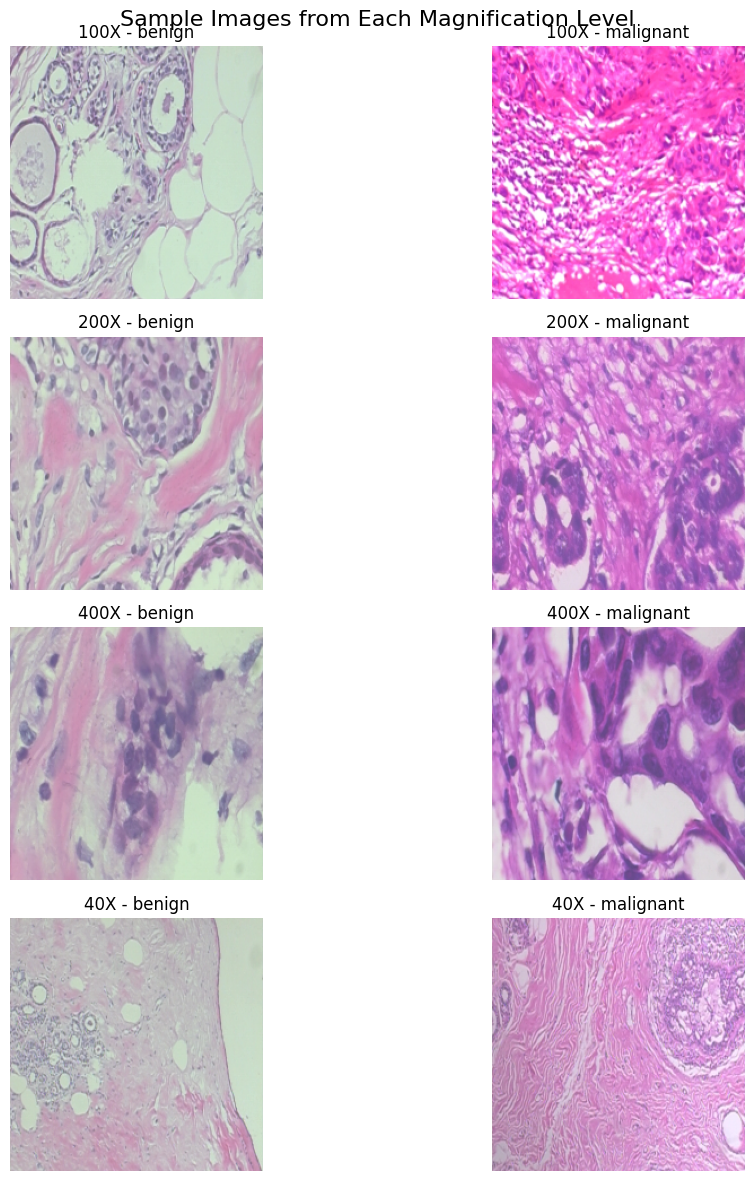

In [ ]:
# Function to display images
def display_images(directory_path):
    fig, axes = plt.subplots(4, 2, figsize=(12, 12))
    fig.suptitle('Sample Images from Each Magnification Level', fontsize=16)

    for i, magnification in enumerate(['100X', '200X', '400X', '40X']):
        mag_path = os.path.join(directory_path, magnification)

        for j, class_name in enumerate(['benign', 'malignant']):
            class_path = os.path.join(mag_path, class_name)
            if os.path.isdir(class_path):
                # Get a sample image file
                sample_image = next((file for file in os.listdir(class_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))), None)
                if sample_image:
                    img_path = os.path.join(class_path, sample_image)
                    img = mpimg.imread(img_path)
                    axes[i, j].imshow(img)
                    axes[i, j].axis('off')
                    axes[i, j].set_title(f'{magnification} - {class_name}')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Display the images
display_images(dataset_path)

###Data Preprocessing

Resizing

In [ ]:
# Define the target size for resizing images
target_size = (224, 224)

def resize_images(directory, magnifications, classes, target_size):
    for magnification in magnifications:
        for class_name in classes:
            subfolder_path = os.path.join(directory, magnification, class_name)

            if not os.path.exists(subfolder_path):
                print(f"Subfolder {subfolder_path} does not exist.")
                continue

            image_files = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]
            if image_files:
                for image_file in image_files:
                    image_path = os.path.join(subfolder_path, image_file)
                    img = cv2.imread(image_path)
                    if img is not None:
                        img_resized = cv2.resize(img, target_size)
                        cv2.imwrite(image_path, img_resized)
                    else:
                        print(f"Failed to read image: {image_path}")
            else:
                print(f"No images found in subfolder: {subfolder_path}")

magnifications = ['40X', '100X', '200X', '400X']
classes = ['benign', 'malignant']
resize_images(dataset_path, magnifications, classes, target_size)

Data augmentation

In [ ]:
class CustomDataGenerator(Sequence):
    def __init__(self, directory, magnifications, classes, target_size, batch_size, shuffle=True):
        self.directory = directory
        self.magnifications = magnifications
        self.classes = classes
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_paths = self._get_image_paths()
        self.on_epoch_end()

        # Define augmentation parameters
        self.datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

    def _get_image_paths(self):
        image_paths = []
        for magnification in self.magnifications:
            for class_name in self.classes:
                class_path = os.path.join(self.directory, magnification, class_name)
                if os.path.isdir(class_path):
                    for file in os.listdir(class_path):
                        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                            image_paths.append((os.path.join(class_path, file), class_name))
        return image_paths

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self._data_generation(batch_paths)
        return X, y

    def _data_generation(self, batch_paths):
        X = np.empty((self.batch_size, *self.target_size, 3))
        y = np.empty((self.batch_size), dtype=int)
        for i, (path, class_name) in enumerate(batch_paths):
            img = cv2.imread(path)
            img = cv2.resize(img, self.target_size)
            img = img / 255.0
            img = np.expand_dims(img, axis=0)  # Expand dims to (1, height, width, channels)
            augmented_img = self.datagen.flow(img, batch_size=1).next()[0]  # Apply augmentation
            X[i,] = augmented_img
            y[i] = self.classes.index(class_name)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_paths)

In [ ]:
dataset_path = "/content/drive/MyDrive/summer research '24/BreakHis/classificacao_binaria"
magnifications = ['40X', '100X', '200X', '400X']
classes = ['benign', 'malignant']
target_size = (224, 224)  # Adjust based on your model requirements
batch_size = 32

train_generator = CustomDataGenerator(
    directory=dataset_path,
    magnifications=magnifications,
    classes=classes,
    target_size=target_size,
    batch_size=batch_size
)


###Sample image of each class after preprocessing


In [ ]:
def display_preprocessed_samples(generator, num_samples=8):
    X, y = generator.get_sample_batch(num_samples)

    # Set up the plot
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 20))
    fig.suptitle('Sample Images After Preprocessing and Augmentation', fontsize=16)

    # Plot each image
    for i in range(num_samples):
        img = X[i]
        axes[i].imshow(img)
        axes[i].axis('off')
        label = generator.classes[y[i]]
        axes[i].set_title(f'Label: {label}')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Display 8 sample images
display_preprocessed_samples(train_generator, num_samples=8)

AttributeError: 'NumpyArrayIterator' object has no attribute 'next'

###Compiling the model

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=5,  # Fewer epochs to start with
    validation_data=validation_generator
)


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
